## Introduction

In  this project we want to provide real estate agencies with an objective criterion that allows them to identify neighborhoods with similar characteristics in two cities without having to know any of them. This will allow them to have satisfied customers as they will move to an environment with the expected characteristics. One of the questions that we will be able to answer with our application is in which neighborhoods of Toronto I will have to move to have characteristics similar to Williamsbridge.


To achieve our goal we are going to use a concept called UQI (Urban Quality Index).Since the beginning of the 20th century, many public and private administrations have worked to measure the quality of cities, neighborhoods, etc. For this, many indicators / indices have been created that allow quantitatively comparing different administrative units with each other. These indicators have several dimensions, some objective such as economic, social, services and other subjective such as the perception that citizens have of their city, neighborhood, etc.

In our project we are going to create three objective dimensions Social, Economic and Services, leaving for other projects the inclusion of a subjective dimension that can be obtained by processing the evaluations of the clients of the places.

Nor are we going to create a UQI, as is usually created, weighting the dimensions and getting a numerical value, but rather we will apply Machine Learning to the dimensions, which we will use as input variables of an unsupervised “Clustering” algorithm.
To weight each of the three dimensions in each neighborhood, we are going to measure the number of places in a radius of 500 meters above the point where it is geolocated, that is, the density. For example, for the Economic dimension we will count how many places of an economic type “Foursquare” returns us.

But "Foursquare" does not manage these variables, so we will have to perform a previous manual task of classifying each one of the "categories" uniquely. For example, "Music Scholl" is labeled as "Social", Internet Café as "Budget" and "Taxi" as "Service".

Therefore, once each neighborhood in New York has the three dimensions weighted, we proceed to classify them into 5 groups as indicated above.
Now we have a dataset with three characteristics and a class. So we can create a model that allows us to predict the class.

Therefore, if we take the neighborhoods of another city and calculate the dimensions for them, we can infer what type of neighborhood belongs to the five that we have, and ultimately we can indicate to a client in New York which neighborhoods in Toronto have characteristics similar to Williamsbridge, such as we said at the beginning.


## Table of Contents


1.  Create New York Venues Grouped by Neigborhoods DATAFREME

2. Clustering Neigborhoods by Dimensions - 5 types

3. Create a Classifier model "K-Nearest Neighbors"

4. Create Toronto Venues Grouped by Neigborhoods DATAFREME

5. Predict Toronto Neigborhoods type
  


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    python_abi-3.7             |          2_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0
  py

<a id='item1'></a>


## 1. Create New York Venues Grouped by Neigborhoods DATAFREME


For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load  the data


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a _pandas_ dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_neighborhoods = newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
newyork_neighborhoods.at[115,'Neighborhood']=newyork_neighborhoods.at[115,'Neighborhood'].replace('Murray Hill','Murray Hill/Manhattan')
newyork_neighborhoods.at[180,'Neighborhood']=newyork_neighborhoods.at[180,'Neighborhood'].replace('Murray Hill','Murray Hill/Queens')


#### Quickly examine the resulting dataframe.


In [7]:
newyork_neighborhoods.head(5)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Create a map of New York with neighborhoods superimposed on top.


In [8]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhoods in zip(newyork_neighborhoods['Latitude'], newyork_neighborhoods['Longitude'], newyork_neighborhoods['Borough'], newyork_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhoods, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Define Foursquare Credentials and Version


In [9]:
#CLIENT_ID = 'your-client-ID' # your Foursquare ID
#CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
CLIENT_ID = 'QL152YWB5GPMKKVSUPNB2HSEAC2ENT3UIFS5DRWVHBMSLWXF' # your Foursquare ID
CLIENT_SECRET = '5A4V1EQEIJKIU40KTWXA1OITNJSHXJVZHLQTIKZEXI5UIYML' # your Foursquare Secret
ACCESS_TOKEN = 'QQF5BYSHBJHL45TFSUUOZFN2Q10HPRMWAP05TUHQ01YPB4CH' # your FourSquare Access Token

VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QL152YWB5GPMKKVSUPNB2HSEAC2ENT3UIFS5DRWVHBMSLWXF
CLIENT_SECRET:5A4V1EQEIJKIU40KTWXA1OITNJSHXJVZHLQTIKZEXI5UIYML


#### Create a categories data frame

In [10]:
# Extract all categories and save on csv file 

m='foursquare'

url_categories = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&m={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    m)


#print(url_categories)



#category_data = newyork_data['features']
results_2 = requests.get(url_categories).json()
results_2

category_data = results_2['response']['categories']
category_data


    
categories_web_df=pd.DataFrame(category_data)

categories_web_df


column_names_categories = ['id_category', 'Name'] 
categories_df= pd.DataFrame(columns=column_names_categories)

for i in categories_web_df.index :
    categories_list=str(categories_web_df.categories[i])
    categories_list=categories_list.split("{")
    del categories_list[0]

    

  
    categories_list


    for category in categories_list:
        
        if category.find("categories") == -1:
            categories = category[7:31]
            name = category.split(",")[3].replace("'shortName':",'').replace("'",'')
            categories_df = categories_df.append({'id_category': categories,'Name': name}, ignore_index=True)


categories_df.to_csv('categories.csv', index = False)
categories_df.head(5)

,id_category,Name
0,56aa371be4b08b9a8d5734db,Amphitheater
1,4fceea171983d5d06c3e9823,Aquarium
2,4bf58dd8d48988d1e1931735,Arcade
3,4bf58dd8d48988d1e2931735,Art Gallery
4,4bf58dd8d48988d1e4931735,Bowling Alley


#### Import a classified categories dataframe (ECO,SOC,SER)

In [11]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_b052ad164f274d0b9ec21008590c5f23 = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_b052ad164f274d0b9ec21008590c5f23 = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_b052ad164f274d0b9ec21008590c5f23 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='4yTxfE_s2nWyNojtR1WiueSib8gnPZpti50FQ8BeM6ZQ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_b052ad164f274d0b9ec21008590c5f23)

body = client_b052ad164f274d0b9ec21008590c5f23.get_object(Bucket='courseracapstoneproject-donotdelete-pr-ilrbhif6fhl0iz',Key='categories_pos (3).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

categories_pos = pd.read_csv(body)
categories_pos.head()


,id_category,Venue Category,index
0,56aa371be4b08b9a8d5734db,Amphitheater,SER
1,4fceea171983d5d06c3e9823,Aquarium,SER
2,4bf58dd8d48988d1e1931735,Arcade,ECO
3,4bf58dd8d48988d1e2931735,Art Gallery,ECO
4,4bf58dd8d48988d1e4931735,Bowling Alley,ECO


####  Categories histogram (ECO,SOC,SER)

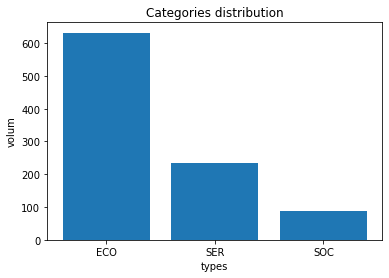

In [12]:
# step 1: get the data
values=categories_pos.groupby(['index']).count()

x_values = ['ECO', 'SER','SOC']
y_values = categories_pos['index'].value_counts().tolist()


plt.title('Categories distribution') 
plt.bar(x_values, y_values)
plt.ylabel('volum')
plt.xlabel('types')
plt.show()
plt.close('all')

In [13]:
def get_category_index(category):

    print(categories_pos['index'] [1])
        
    return '1'

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<a id='item2'></a>


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan


In [15]:
def getNearbyVenues(names_b,names_n, latitudes, longitudes, radius=500):

    venues_list=[]
    for names_b,names_n,lat, lng in zip(names_b, names_n,latitudes, longitudes):
        #print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            names_b,
            names_n,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _newyork_venues_.


In [16]:
# type your answer here no ejecutar
newyork_venues = getNearbyVenues(names_b=newyork_neighborhoods['Borough'],names_n=newyork_neighborhoods['Neighborhood'],
                                   latitudes=newyork_neighborhoods['Latitude'],
                                   longitudes=newyork_neighborhoods['Longitude']
                                  )

newyork_venues.insert(0, 'City', "NewYork")

In [17]:
newyork_venues.shape



(7874, 9)

#### Let's find out how many unique categories can be curated from all the returned venues


In [18]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 415 uniques categories.


#### Let's create a function to return category index (ECO,SOC,SER) 

In [19]:
def get_category_index(category):
    
         
                
        for i in categories_pos.index:
                if categories_pos['Venue Category'] [i] == category:
                    return categories_pos['index'] [i] 
        
        #By default return SER if not recognize categogy      
        return 'ECO'

#### Let's classify all venues with one dimension (ECO,SOC,SER) 

In [20]:
result=pd.DataFrame()


for i in newyork_venues.index:
    
        City= newyork_venues["City"][i]
        Borough	= newyork_venues["Borough"] [i]	
        Neighborhood = newyork_venues["Neighborhood"] [i]	 
        Neighborhood_Latitude =	newyork_venues ["Neighborhood Latitude"] [i]
        Neighborhood_Longitude = newyork_venues	["Neighborhood Longitude"] [i]
        Venue = newyork_venues ["Venue"] [i]
        Venue_Latitude = newyork_venues	["Venue Latitude"] [i]	
        Venue_Longitude	= newyork_venues ["Venue Longitude"] [i]	
        Venue_Category = newyork_venues ["Venue Category"] [i]
        index_d =  get_category_index(Venue_Category) 
     

    
        result =  result.append({'City': City,
                            'Borough': Borough,
                            'Neighborhood': Neighborhood,
                            'Neighborhood Latitude': Neighborhood_Latitude,
                            'Neighborhood Longitude': Neighborhood_Longitude,
                            'Venue':  Venue ,
                            'Venue Latitude': Venue_Latitude,
                            'Venue Longitude': Venue_Longitude,
                            'Venue Category': Venue_Category,
                            'index':  index_d                                      
                                }, ignore_index=True)

result.head(5)

,Borough,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,index
0,Bronx,NewYork,Wakefield,40.894705,-73.847201,Lollipops Gelato,Dessert Shop,40.894123,-73.845892,ECO
1,Bronx,NewYork,Wakefield,40.894705,-73.847201,Rite Aid,Pharmacy,40.896649,-73.844846,ECO
2,Bronx,NewYork,Wakefield,40.894705,-73.847201,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568,ECO
3,Bronx,NewYork,Wakefield,40.894705,-73.847201,Walgreens,Pharmacy,40.896528,-73.844700,ECO
4,Bronx,NewYork,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,ECO


In [21]:
result.head(20)

,Borough,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,index
0,Bronx,NewYork,Wakefield,40.894705,-73.847201,Lollipops Gelato,Dessert Shop,40.894123,-73.845892,ECO
1,Bronx,NewYork,Wakefield,40.894705,-73.847201,Rite Aid,Pharmacy,40.896649,-73.844846,ECO
2,Bronx,NewYork,Wakefield,40.894705,-73.847201,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568,ECO
3,Bronx,NewYork,Wakefield,40.894705,-73.847201,Walgreens,Pharmacy,40.896528,-73.844700,ECO
4,Bronx,NewYork,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,ECO
5,Bronx,NewYork,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,Caribbean Restaurant,40.898083,-73.850259,ECO
6,Bronx,NewYork,Wakefield,40.894705,-73.847201,Subway,Sandwich Place,40.890468,-73.849152,ECO
7,Bronx,NewYork,Wakefield,40.894705,-73.847201,Central Deli,Deli / Bodega,40.896728,-73.844387,ECO
8,Bronx,NewYork,Wakefield,40.894705,-73.847201,Koss Quick Wash,Laundromat,40.891281,-73.849904,ECO
9,Bronx,NewYork,Co-op City,40.874294,-73.829939,Dollar Tree,Discount Store,40.870125,-73.828989,ECO


####  Venues Categories histogram (ECO,SOC,SER)

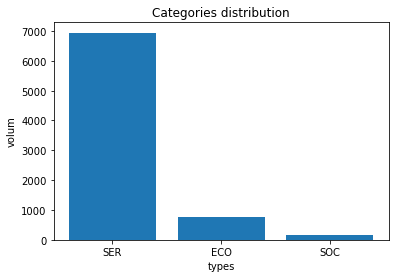

In [22]:
# step 1: get the data
#values=result.groupby(['index']).count()

x_values = ['SER', 'ECO','SOC']
y_values = result['index'].value_counts().tolist()


plt.title('Categories distribution') 
plt.bar(x_values, y_values)
plt.ylabel('volum')
plt.xlabel('types')
plt.show()
plt.close('all')

####  Split index column into (ECO,SOC,SER)

In [23]:
# one hot encoding
newyork_onehot = pd.get_dummies(result[['index']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood']  = result['Neighborhood']  
newyork_onehot['City']  = result['City']  
newyork_onehot['Borough']  = result['Borough']  
# move neighborhood column to the first column
newyork_onehot = newyork_onehot.reindex(columns=['City','Borough','Neighborhood','ECO','SER','SOC'])
#newyork_onehot = newyork_onehot.reindex(columns=['Neighborhood','ECO','SER','SOC'])
#fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
#newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head(10)

,City,Borough,Neighborhood,ECO,SER,SOC
0,NewYork,Bronx,Wakefield,1,0,0
1,NewYork,Bronx,Wakefield,1,0,0
2,NewYork,Bronx,Wakefield,1,0,0
3,NewYork,Bronx,Wakefield,1,0,0
4,NewYork,Bronx,Wakefield,1,0,0
5,NewYork,Bronx,Wakefield,1,0,0
6,NewYork,Bronx,Wakefield,1,0,0
7,NewYork,Bronx,Wakefield,1,0,0
8,NewYork,Bronx,Wakefield,1,0,0
9,NewYork,Bronx,Co-op City,1,0,0


In [24]:
newyork_onehot.shape

(7874, 6)

#### Next, let's group rows by neighborhood and by taking sum of occurrence of each category


In [25]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').sum().reset_index()
newyork_grouped.head(5)


,Neighborhood,ECO,SER,SOC
0,Allerton,26,1,0
1,Annadale,9,1,0
2,Arden Heights,3,1,0
3,Arlington,6,3,0
4,Arrochar,15,4,0


#### Let's confirm the new size


In [26]:
newyork_grouped.shape

(302, 4)

First, let's write a function to sort the venues in descending order.


<a id='item4'></a>


In [27]:
newyork_cluster = newyork_grouped.drop('Neighborhood', axis=1)
newyork_cluster.head()

,ECO,SER,SOC
0,26,1,0
1,9,1,0
2,3,1,0
3,6,3,0
4,15,4,0


In [28]:
newyork_grouped.head(5)

,Neighborhood,ECO,SER,SOC
0,Allerton,26,1,0
1,Annadale,9,1,0
2,Arden Heights,3,1,0
3,Arlington,6,3,0
4,Arrochar,15,4,0


Run _k_-means to cluster the neighborhood into 5 clusters.


## 2. Clustering Neigborhoods by Dimensions - 5 types

In [29]:
from sklearn.preprocessing import StandardScaler

X = newyork_grouped.values[:,1:]
X = np.nan_to_num(X)
newyork_cluster = StandardScaler().fit_transform(X)
newyork_cluster

array([[ 1.89539565e-01, -6.10671059e-01, -5.08850815e-01],
       [-8.80973227e-01, -6.10671059e-01, -5.08850815e-01],
       [-1.25880127e+00, -6.10671059e-01, -5.08850815e-01],
       [-1.06988725e+00,  1.87695434e-01, -5.08850815e-01],
       [-5.03145183e-01,  5.86878680e-01, -5.08850815e-01],
       [-5.66116523e-01,  1.78442842e+00, -5.08850815e-01],
       [ 1.57490906e+00, -1.00985430e+00,  1.33154375e+00],
       [-8.18001886e-01,  5.86878680e-01,  4.11346467e-01],
       [-3.77202501e-01, -2.11487812e-01, -5.08850815e-01],
       [ 1.51193772e+00,  1.87695434e-01, -5.08850815e-01],
       [ 5.67367610e-01,  4.97789439e+00,  2.25174103e+00],
       [ 1.70085174e+00, -1.00985430e+00, -5.08850815e-01],
       [ 1.38599504e+00, -2.11487812e-01,  4.11346467e-01],
       [-1.88288479e-01, -6.10671059e-01, -5.08850815e-01],
       [ 1.63788040e+00, -1.00985430e+00,  4.11346467e-01],
       [-1.44771529e+00, -6.10671059e-01, -5.08850815e-01],
       [ 5.67367610e-01,  5.86878680e-01

In [30]:
# set number of clusters
kclusters = 5

newyork_cluster = newyork_grouped.drop('Neighborhood', axis=1)

#manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_cluster)

# check cluster labels generated for each row in the dataframe
labels=kmeans.labels_
labels.shape


(302,)

In [31]:
# add clustering labels
newyork_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_print = newyork_neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
newyork_print = newyork_print.join(newyork_grouped.set_index('Neighborhood'), on='Neighborhood')
newyork_print=newyork_print.dropna()




In [32]:
newyork_print.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,ECO,SER,SOC
0,Bronx,Wakefield,40.894705,-73.847201,3.0,9.0,0.0,0.0
1,Bronx,Co-op City,40.874294,-73.829939,3.0,12.0,4.0,0.0
2,Bronx,Eastchester,40.887556,-73.827806,3.0,17.0,4.0,0.0
3,Bronx,Fieldston,40.895437,-73.905643,2.0,0.0,4.0,0.0
4,Bronx,Riverdale,40.890834,-73.912585,2.0,2.0,7.0,1.0


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_print['Latitude'], newyork_print['Longitude'], newyork_print['Neighborhood'], newyork_print['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
folium.CircleMarker(
    [40.876551,-73.910660],
    radius=2,
    popup="punto",
    color=rainbow[1],
    fill=False,
    fill_color=rainbow[1],
    fill_opacity=0.1).add_to(map_clusters)


map_clusters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f855e1a3ad0>]],
      dtype=object)

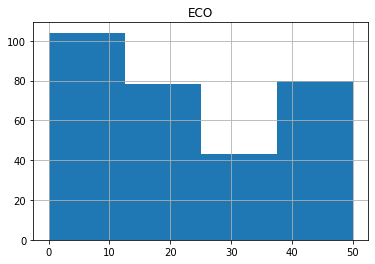

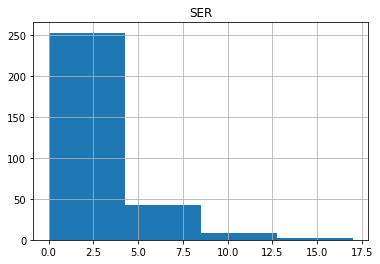

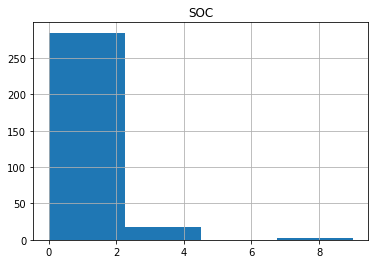

In [34]:
newyork_print.hist(column='ECO', bins=4)
newyork_print.hist(column='SER', bins=4)
newyork_print.hist(column='SOC', bins=4)

<a id='item5'></a>


#### Let's explore the clusters

#### Cluster 0


In [35]:
Cluster0=newyork_print.loc[newyork_print['Cluster Labels'] == 0, newyork_print.columns[[1] + list(range(5, newyork_print.shape[1]))]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85526abdd0>]],
      dtype=object)

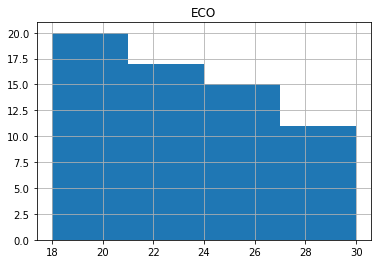

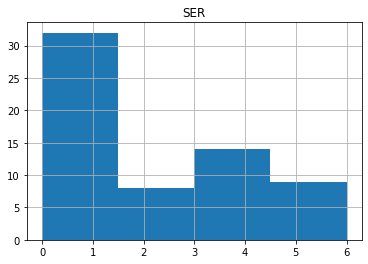

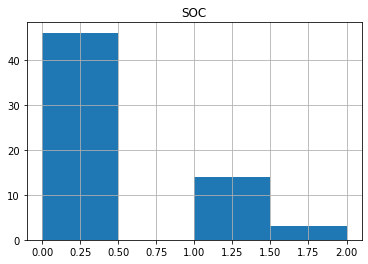

In [36]:
Cluster0.hist(column='ECO', bins=4)
Cluster0.hist(column='SER', bins=4)
Cluster0.hist(column='SOC', bins=4)


#### Cluster 1


In [37]:
Cluster1=newyork_print.loc[newyork_print['Cluster Labels'] == 1, newyork_print.columns[[1] + list(range(5, newyork_print.shape[1]))]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f855e04dad0>]],
      dtype=object)

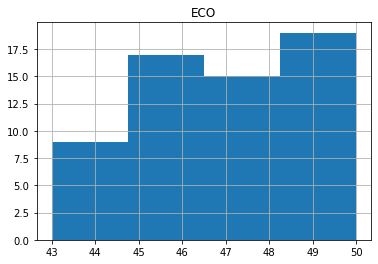

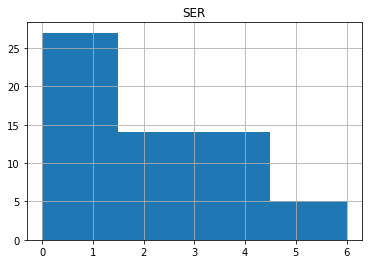

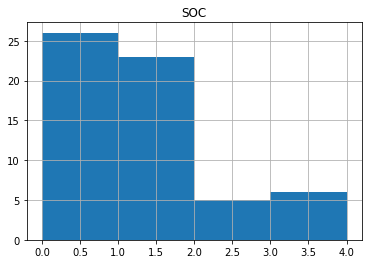

In [38]:
Cluster1.hist(column='ECO', bins=4)
Cluster1.hist(column='SER', bins=4)
Cluster1.hist(column='SOC', bins=4)

#### Cluster 2


In [39]:
Cluster2=newyork_print.loc[newyork_print['Cluster Labels'] == 2, newyork_print.columns[[1] + list(range(5, newyork_print.shape[1]))]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85511f4310>]],
      dtype=object)

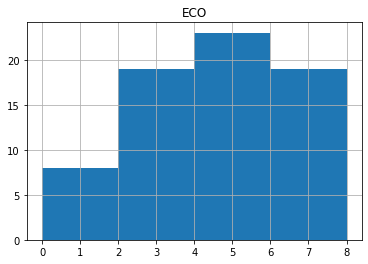

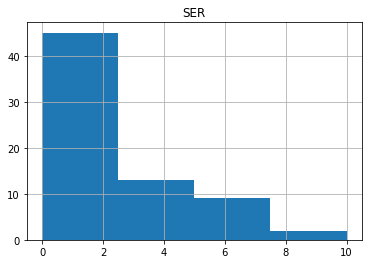

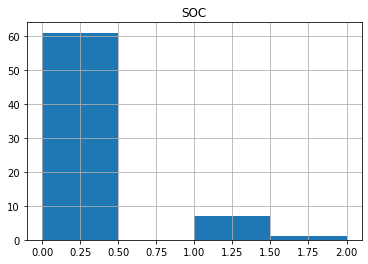

In [40]:
Cluster2.hist(column='ECO', bins=4)
Cluster2.hist(column='SER', bins=4)
Cluster2.hist(column='SOC', bins=4)

#### Cluster 3


In [41]:
Cluster3=newyork_print.loc[newyork_print['Cluster Labels'] == 3, newyork_print.columns[[1] + list(range(5, newyork_print.shape[1]))]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85510648d0>]],
      dtype=object)

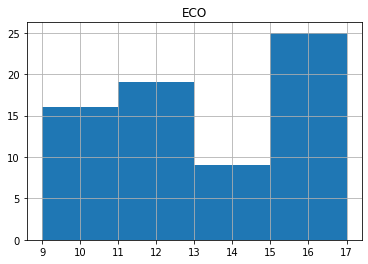

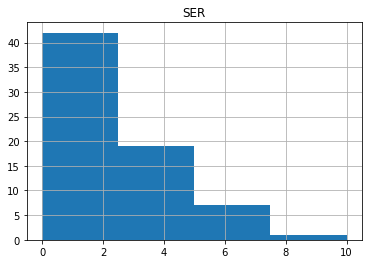

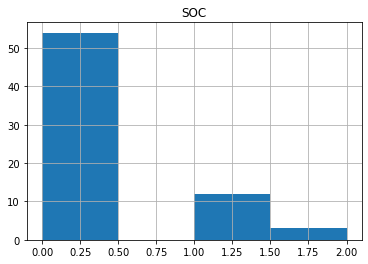

In [42]:
Cluster3.hist(column='ECO', bins=4)
Cluster3.hist(column='SER', bins=4)
Cluster3.hist(column='SOC', bins=4)

#### Cluster 4


In [43]:
Cluster4=newyork_print.loc[newyork_print['Cluster Labels'] == 4, newyork_print.columns[[1] + list(range(5, newyork_print.shape[1]))]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85526b61d0>]],
      dtype=object)

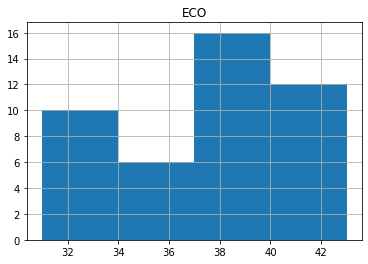

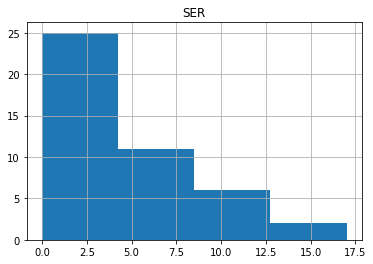

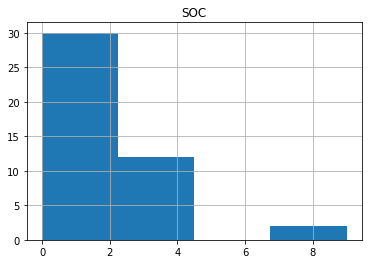

In [44]:
Cluster4.hist(column='ECO', bins=4)
Cluster4.hist(column='SER', bins=4)
Cluster4.hist(column='SOC', bins=4)

## 3. Create a Classifier model "K-Nearest Neighbors"

In [45]:
!pip install scikit-learn==0.23.1

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 6.8 MB 10.3 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [46]:
from sklearn import preprocessing
%matplotlib inline

In [47]:
X = newyork_print[['ECO', 'SER','SOC']] .values  #.astype(float)
X[0:5]



array([[ 9.,  0.,  0.],
       [12.,  4.,  0.],
       [17.,  4.,  0.],
       [ 0.,  4.,  0.],
       [ 2.,  7.,  1.]])

In [48]:
newyork_print.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,ECO,SER,SOC
0,Bronx,Wakefield,40.894705,-73.847201,3.0,9.0,0.0,0.0
1,Bronx,Co-op City,40.874294,-73.829939,3.0,12.0,4.0,0.0
2,Bronx,Eastchester,40.887556,-73.827806,3.0,17.0,4.0,0.0
3,Bronx,Fieldston,40.895437,-73.905643,2.0,0.0,4.0,0.0
4,Bronx,Riverdale,40.890834,-73.912585,2.0,2.0,7.0,1.0


In [49]:
y = newyork_print['Cluster Labels'].values
y[0:5]

array([3., 3., 3., 2., 2.])

In [50]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.89081803, -1.01207582, -0.51885079],
       [-0.70244306,  0.57498395, -0.51885079],
       [-0.38848477,  0.57498395, -0.51885079],
       [-1.45594294,  0.57498395, -0.51885079],
       [-1.33035963,  1.76527877,  0.39062905]])

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (244, 3) (244,)
Test set: (61, 3) (61,)


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [54]:


Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9180327868852459
Test set Accuracy:  0.9016393442622951


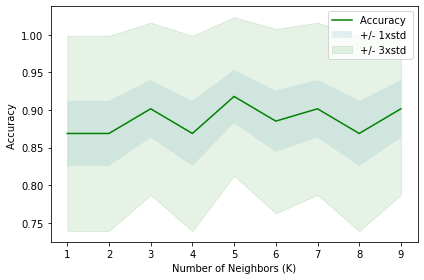

In [55]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [56]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.9180327868852459 with k= 5


#### Train with the best Kn in this case 5

In [57]:
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier()

In [58]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([4., 0., 2., 4., 2.])

In [59]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9221311475409836
Test set Accuracy:  0.9180327868852459


## 4. Create Toronto Venues Grouped by Neigborhoods DATAFREME

In [60]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html

    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Solving environment: done

# All requested packages already installed.

Solving environment:

In [61]:
html="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(html)
soup = BeautifulSoup(html_data.text, 'html5lib')

In [62]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighbourhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [63]:
Toronto_neighborhoods=pd.DataFrame(table_contents)
Toronto_neighborhoods['Borough']=Toronto_neighborhoods['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [64]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')


#merge two data frames

lat_lon.rename(columns={'Postal Code':'PostalCode'},inplace=True)
lat_lon
Toronto_neighborhoods = pd.merge(Toronto_neighborhoods,lat_lon,on='PostalCode')

In [65]:
Toronto_neighborhoods.to_csv("Toronto_neighborhoods.csv")

In [66]:
Toronto_neighborhoods.head(5)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [67]:
# type your answer here no ejecutar
toronto_venues = getNearbyVenues(names_b=Toronto_neighborhoods['Borough'],names_n=Toronto_neighborhoods['Neighbourhood'],
                                   latitudes=Toronto_neighborhoods['Latitude'],
                                   longitudes=Toronto_neighborhoods['Longitude']
                                  )

toronto_venues.insert(0, 'City', "Toronto")

In [68]:
void=pd.DataFrame()

result=void


for i in toronto_venues.index:
    
        City= toronto_venues["City"][i]
        Borough	= toronto_venues["Borough"] [i]	
        Neighborhood = toronto_venues["Neighborhood"] [i]	 
        Neighborhood_Latitude =	toronto_venues ["Neighborhood Latitude"] [i]
        Neighborhood_Longitude = toronto_venues	["Neighborhood Longitude"] [i]
        Venue = toronto_venues ["Venue"] [i]
        Venue_Latitude = toronto_venues	["Venue Latitude"] [i]	
        Venue_Longitude	= toronto_venues ["Venue Longitude"] [i]	
        Venue_Category = toronto_venues ["Venue Category"] [i]
        index_d =  get_category_index(Venue_Category) 
     

    
        result =  result.append({'City': City,
                            'Borough': Borough,
                            'Neighborhood': Neighborhood,
                            'Neighborhood Latitude': Neighborhood_Latitude,
                            'Neighborhood Longitude': Neighborhood_Longitude,
                            'Venue':  Venue ,
                            'Venue Latitude': Venue_Latitude,
                            'Venue Longitude': Venue_Longitude,
                            'Venue Category': Venue_Category,
                            'index':  index_d                                      
                                }, ignore_index=True)

In [69]:
result.head(5)

,Borough,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,index
0,North York,Toronto,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park,43.751976,-79.332140,SER
1,North York,Toronto,Parkwoods,43.753259,-79.329656,KFC,Fast Food Restaurant,43.754387,-79.333021,ECO
2,North York,Toronto,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop,43.751974,-79.333114,ECO
3,North York,Toronto,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,ECO
4,North York,Toronto,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop,43.725517,-79.313103,ECO


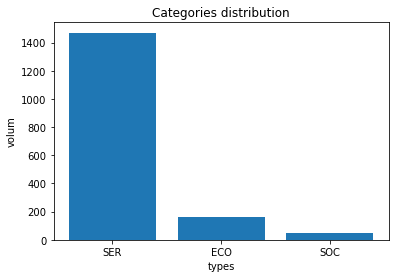

In [70]:
# step 1: get the data
values=result.groupby(['index']).count()

x_values = ['SER', 'ECO','SOC']
y_values = result['index'].value_counts().tolist()


plt.title('Categories distribution') 
plt.bar(x_values, y_values)
plt.ylabel('volum')
plt.xlabel('types')
plt.show()
plt.close('all')

In [71]:
# one hot encoding
toronto_onehot = pd.get_dummies(result[['index']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood']  = result['Neighborhood']  
toronto_onehot['City']  = result['City']  
toronto_onehot['Borough']  = result['Borough']  
# move neighborhood column to the first column
toronto_onehot = toronto_onehot.reindex(columns=['City','Borough','Neighborhood','ECO','SER','SOC'])
#newyork_onehot = newyork_onehot.reindex(columns=['Neighborhood','ECO','SER','SOC'])
#fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
#newyork_onehot = newyork_onehot[fixed_columns]

toronto_onehot.head(10)

,City,Borough,Neighborhood,ECO,SER,SOC
0,Toronto,North York,Parkwoods,0,1,0
1,Toronto,North York,Parkwoods,1,0,0
2,Toronto,North York,Parkwoods,1,0,0
3,Toronto,North York,Victoria Village,1,0,0
4,Toronto,North York,Victoria Village,1,0,0
5,Toronto,North York,Victoria Village,1,0,0
6,Toronto,North York,Victoria Village,0,1,0
7,Toronto,North York,Victoria Village,1,0,0
8,Toronto,Downtown Toronto,"Regent Park, Harbourfront",1,0,0
9,Toronto,Downtown Toronto,"Regent Park, Harbourfront",1,0,0


In [72]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head(5)
toronto_grouped.to_csv('toronto_grouped.csv')

In [73]:
toronto_grouped.shape

(98, 4)

In [74]:
X_test = toronto_grouped.values[:,1:]
X_test = np.nan_to_num(X_test)
X_test= StandardScaler().fit_transform(X_test)
X_test

array([[-0.76828554, -0.319984  , -0.60800622],
       [-0.57621416, -0.319984  ,  0.68731137],
       [ 0.44816657, -0.319984  , -0.60800622],
       [-0.70426175, -0.8099595 , -0.60800622],
       [ 0.51219036, -0.8099595 , -0.60800622],
       [ 1.92071385,  1.1499425 ,  0.68731137],
       [-0.76828554, -0.319984  , -0.60800622],
       [ 0.38414277,  0.659967  ,  0.68731137],
       [-0.19207139,  2.12989351, -0.60800622],
       [-0.83230934,  0.1699915 , -0.60800622],
       [-0.44816657, -0.319984  , -0.60800622],
       [ 2.04876144,  0.1699915 ,  0.68731137],
       [-0.19207139,  0.659967  , -0.60800622],
       [ 1.98473765,  0.1699915 ,  1.98262896],
       [-0.70426175, -0.319984  , -0.60800622],
       [-0.19207139, -0.8099595 , -0.60800622],
       [-0.89633313, -0.319984  , -0.60800622],
       [ 1.53657108,  2.61986901,  4.57326414],
       [ 1.15242831, -0.319984  ,  1.98262896],
       [-0.64023795,  0.1699915 ,  0.68731137],
       [-0.64023795, -0.8099595 , -0.608

In [75]:
yhat = neigh.predict(X_test)

In [76]:
# add clustering labels
#toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_grouped.insert(0, 'Cluster Labels', yhat)
toronto_print = Toronto_neighborhoods
toronto_print.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)
toronto_print = toronto_print.join(toronto_grouped.set_index('Neighborhood'), on='Neighborhood')
toronto_print=toronto_print.dropna()


In [77]:
toronto_grouped=toronto_grouped.drop(columns=['Cluster Labels'])

In [78]:
toronto_grouped.head(4)

,Neighborhood,ECO,SER,SOC
0,Agincourt,3,1,0
1,"Alderwood, Long Branch",6,1,1
2,"Bathurst Manor, Wilson Heights, Downsview North",22,1,0
3,Bayview Village,4,0,0


In [79]:
toronto_print.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,ECO,SER,SOC
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,2.0,1.0,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,3.0,4.0,1.0,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4.0,37.0,6.0,2.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,11.0,0.0,0.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,4.0,29.0,1.0,2.0


In [80]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_print['Latitude'], toronto_print['Longitude'], toronto_print['Neighborhood'], toronto_print['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

map_clusters